In [1]:
!pip install --upgrade flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax.numpy as jnp
import numpy as np
from jax import random, vmap, grad, jit
from jax.nn import one_hot

import flax.linen as nn
import optax
from sklearn.metrics import confusion_matrix

from typing import Any, Callable, Sequence, Optional, Union, Dict

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
# Some helper functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5,4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)   
          plt.imshow(conv[0,:,:,cnt]) 
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [4]:
class ConvNet(nn.Module):
    out_channels: Sequence[int]
    out_dim: int=8
    activation: Callable=nn.gelu

    @nn.compact
    def __call__(self, x):
        for i in range(len(self.out_channels)):
            x = nn.Conv(self.out_channels[i],  kernel_size=(5,5), strides=(1,1), padding="SAME")(x)
            x = self.activation(x)
            x = nn.max_pool(x, (2,2), (2,2))
        x = nn.Dense(self.out_dim)(x.flatten())
        return nn.softmax(x)

In [5]:
class CNNclassifier:
    # Initialize the class
    def __init__(self, arch, rng_key=random.PRNGKey(0)):
        
        # Initialization and evaluation functions
        inputs = jnp.ones((28,28,1))
        self.model = arch
        self.params = self.model.init(rng_key, inputs)
        print(self.model.tabulate(rng_key, inputs))
        self.apply = vmap(self.model.apply, in_axes=(None,0))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        images, labels = batch
        outputs = self.apply(params, images)
        loss = -labels*jnp.log(outputs)
        return jnp.mean(loss)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

In [6]:
import torchvision as tv

# Training data
train = tv.datasets.MNIST('./', download=True, train=True)
train_images = jnp.array(train.data.numpy())
train_labels = jnp.array(train.targets.numpy())

# Input shape should be (NxWxHxC) and normalized to [0,1]
train_images = train_images[:,:,:,jnp.newaxis]/255.
# Labels should be a one-hot vector
num_classes = train_labels.max()+1
train_labels = one_hot(train_labels, num_classes)

In [7]:
from torch.utils import data

class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [8]:
# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128)
data = iter(train_dataset)
batch = next(data)

In [9]:
inputs, targets = batch
print(inputs.shape)

(128, 28, 28, 1)


In [11]:
# Initialize model
arch = ConvNet(out_channels=(8, 16, 32),
               out_dim=num_classes,
               activation=nn.gelu)
model = CNNclassifier(arch)


                                ConvNet Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs           ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ ConvNet │ float32[28,28,1] │ float32[10]       │ Conv_0:           │
│         │         │                  │                   │   bias:           │
│         │         │                  │                   │ float32[8]        │
│         │         │                  │                   │   kernel:         │
│         │         │                  │                   │ float32[5,5,1,8]  │
│         │         │                  │                   │ Conv_1:           │
│         │         │                  │                   │   bias:           │
│         │         │                  │                   │ float32[16]       │
│         │         │      

100%|██████████| 5000/5000 [00:18<00:00, 272.18it/s, loss=0.00036725946]


Text(0, 0.5, 'Loss')

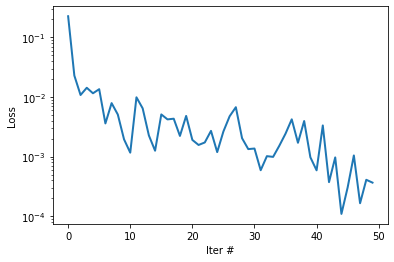

In [12]:
# Train model
model.train(train_dataset, nIter=5000)

# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [13]:
# Test data
test = tv.datasets.MNIST('./', download=True, train=False)
test_images = jnp.array(test.data.numpy())
test_labels = jnp.array(test.targets.numpy())

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:,jnp.newaxis]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

In [15]:
# Compute classification accuracy on the entire test data-set
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model.apply(params, images)
    pred_class = jnp.argmax(outputs,1)
    true_class = jnp.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(model.params, (test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 99.0199966430664%


In [ ]:
# Plot the confusion matrix
outputs = model.model.apply(model.params, test_images)
pred_class = jnp.argmax(outputs,1)
true_class = jnp.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

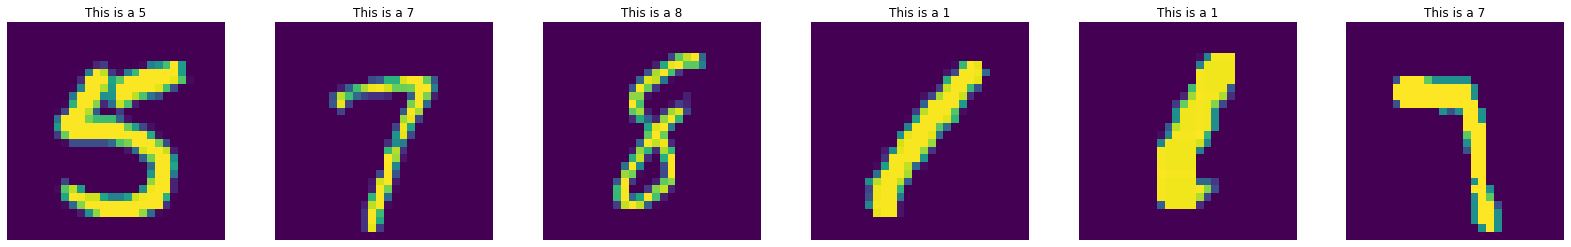

In [16]:
# Visualize some predictions
batch = next(test_data)
images, labels = batch
plt.figure(figsize=(28,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    outputs = model.apply(model.params, images[i:i+1,...])
    pred_class = np.argmax(outputs,1)
    plt.imshow(images[i,:,:,0])
    plt.axis('off')
    plt.title('This is a {}'.format(pred_class[0]))